# Task 2: Building the baseline mode

In [ ]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, Input, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomTranslation, RandomZoom


import os
import numpy as np
import matplotlib.pyplot as plt
import pathlib

import functions_ai

In [180]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## 1) Setup 

In [181]:
metrics = [
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')] #compare different metrics

# Set random seed
np.random.seed(42)
tf.random.set_seed(42)

## 2) Build Initial Model

In [182]:
custom_preprocessing = functions_ai.custom_preprocessing
BATCH_SIZE = 128
IMG_HEIGHT = IMG_WIDTH = 128
EPOCHS = 30
dropout_rate = 0.5

In [183]:
#set the paths/directories
path = pathlib.Path('covid xray')
train_dir = os.path.join(path, 'train') 
validation_dir = os.path.join(path, 'val')
test_dir = os.path.join(path, 'test')

train_covid_dir = os.path.join(train_dir, 'COVID')
train_normal_dir = os.path.join(train_dir, 'NORMAL')

validation_covid_dir = os.path.join(validation_dir, 'COVID')
validation_normal_dir = os.path.join(validation_dir, 'NORMAL')

test_covid_dir = os.path.join(test_dir, 'COVID')
test_normal_dir = os.path.join(test_dir, 'NORMAL')

#print(train_dir)

In [184]:
train_data_gen = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                             label_mode='binary',
                                                             batch_size=BATCH_SIZE,
                                                             image_size=(IMG_HEIGHT, IMG_WIDTH))
val_data_gen = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                           label_mode='binary',
                                                           batch_size=BATCH_SIZE,
                                                           image_size=(IMG_HEIGHT, IMG_WIDTH))
test_data_gen = tf.keras.utils.image_dataset_from_directory(test_dir, 
                                                            label_mode = 'binary', 
                                                            batch_size = BATCH_SIZE,
                                                            image_size=(IMG_HEIGHT, IMG_WIDTH), 
                                                            #shuffle = False) #set shuffle = False when running/computing the covariance matrix
                                                            shuffle = True) #set shuffle = True for visual evaluation 

                                                             #when changed remember to run the 3 blocks code below

Found 1600 files belonging to 2 classes.
Found 400 files belonging to 2 classes.
Found 200 files belonging to 2 classes.


In [185]:
def preprocess_image(transform):
    
    def _preprocess(image, label):
        return transform(image), label
        
    return _preprocess

In [186]:
rescale = Rescaling(1 / 255)

In [187]:
train_data_preproc = train_data_gen.map(preprocess_image(rescale))
val_data_preproc = val_data_gen.map(preprocess_image(rescale))
test_data_preproc = test_data_gen.map(preprocess_image(rescale))

In [188]:
train_data_preproc = train_data_preproc.cache()
val_data_preproc = val_data_preproc.cache()
test_data_preproc = test_data_preproc.cache()

In [189]:
def plot_images(images_arr, labels_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, label, ax in zip(images_arr, labels_arr, axes):
        ax.imshow(img)
        ax.set_title(labels[int(label)], fontsize=14)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

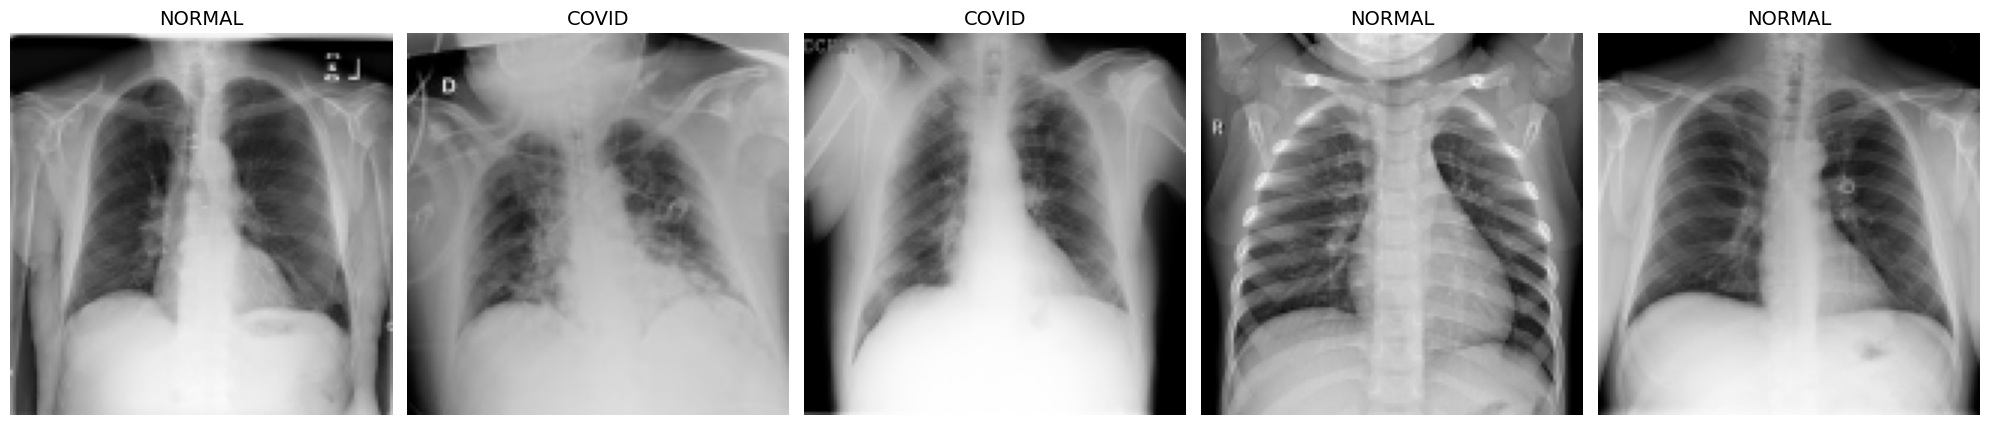

In [190]:
labels = train_data_gen.class_names

first_batch_images, first_batch_labels = next(iter(train_data_preproc))
plot_images(first_batch_images[:5], first_batch_labels[:5])

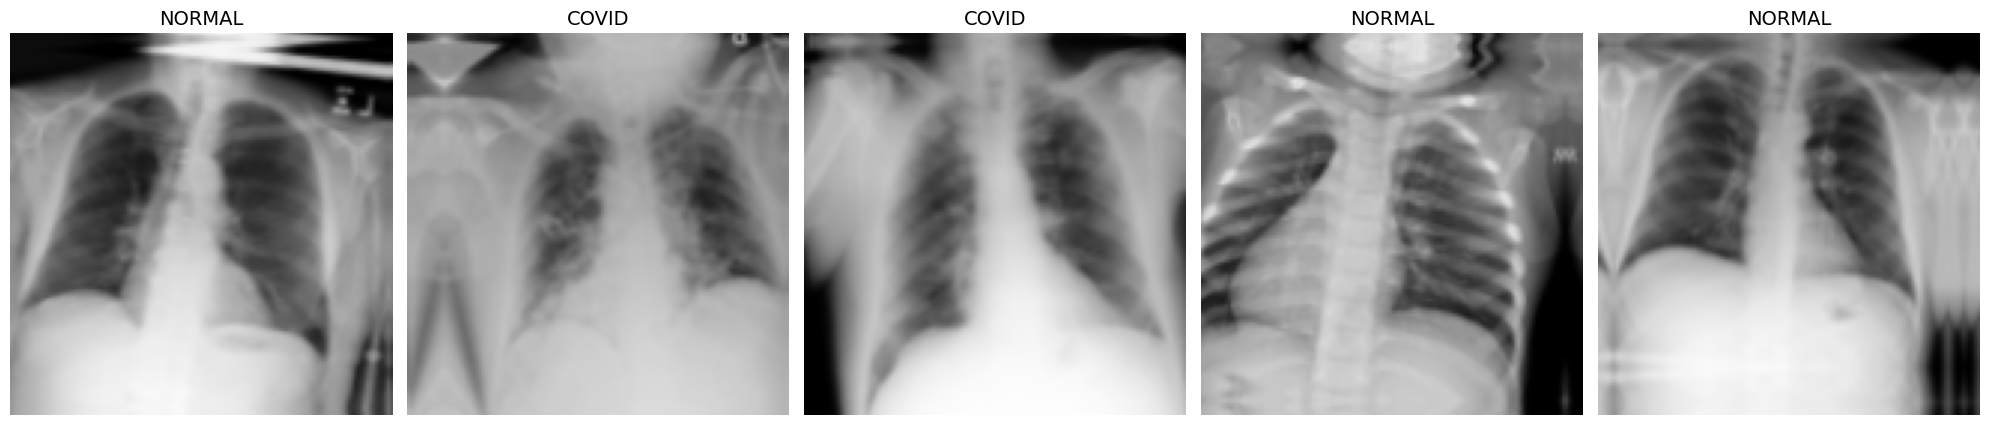

In [191]:
flip =  RandomFlip("horizontal")
rotate = RandomRotation(factor=(-1/24, 1/24))  #you could set the factor higher, for example factor = 1/12
zoom = RandomZoom(height_factor=0.1, width_factor=0.1)
translate =  RandomTranslation(height_factor=0.10, width_factor=0.10)
augment = Sequential((flip, rotate, translate, zoom))
plot_images(map(augment, first_batch_images[:5]),first_batch_labels[:5]) 

In [192]:
model = Sequential([
    Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    flip,
    rotate, 
    translate,
    zoom,
    Conv2D(16, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(dropout_rate),
    Dense(128, activation = 'relu'), #added to fullfill the assignment correctly
    Dense(1, activation='sigmoid')
])


In [195]:
model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(), metrics=metrics)

In [196]:
model.summary()

Model: "sequential_76"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip_11 (RandomFlip)     │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_11              │ (None, 128, 128, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_translation_5            │ (None, 128, 128, 3)    │             0 │
│ (RandomTranslation)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_17 (RandomZoom)     │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_195 (Conv2D)             │ (None, 128, 128, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_195               │ (None, 64, 64, 16)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_196 (Conv2D)             │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_196               │ (None, 32, 32, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_197 (Conv2D)             │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_197               │ (None, 16, 16, 64)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_65 (Flatten)            │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_189 (Dense)               │ (None, 512)            │     8,389,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_60 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_190 (Dense)               │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_191 (Dense)               │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,478,497 (32.34 MB)

 Trainable params: 8,478,497 (32.34 MB)

 Non-trainable params: 0 (0.00 B)

## 3) Train Your Model

In [197]:
history = model.fit(
    train_data_preproc,
    epochs=EPOCHS,
    validation_data=val_data_preproc,
)

Epoch 1/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 18s 732ms/step - accuracy: 0.5034 - auc: 0.5259 - loss: 0.9022 - precision: 0.4988 - recall: 0.5521 - val_accuracy: 0.5000 - val_auc: 0.6745 - val_loss: 0.6901 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 2/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 516ms/step - accuracy: 0.6423 - auc: 0.7502 - loss: 0.6465 - precision: 0.6132 - recall: 0.8085 - val_accuracy: 0.6300 - val_auc: 0.7027 - val_loss: 0.6415 - val_precision: 0.6150 - val_recall: 0.6950
Epoch 3/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 565ms/step - accuracy: 0.7655 - auc: 0.8333 - loss: 0.5099 - precision: 0.7538 - recall: 0.7797 - val_accuracy: 0.6525 - val_auc: 0.6943 - val_loss: 0.6491 - val_precision: 0.6685 - val_recall: 0.6050
Epoch 4/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 567ms/step - accuracy: 0.7994 - auc: 0.8534 - loss: 0.4774 - precision: 0.8025 - recall: 0.7865 - val_accuracy: 0.6300 - val_auc: 0.7379 - val_loss: 0.6308 - val_precision: 0.5985 - val_recall: 0.7900
Epoch 5/30
13/13 ━━━━━━━━━━━━━━

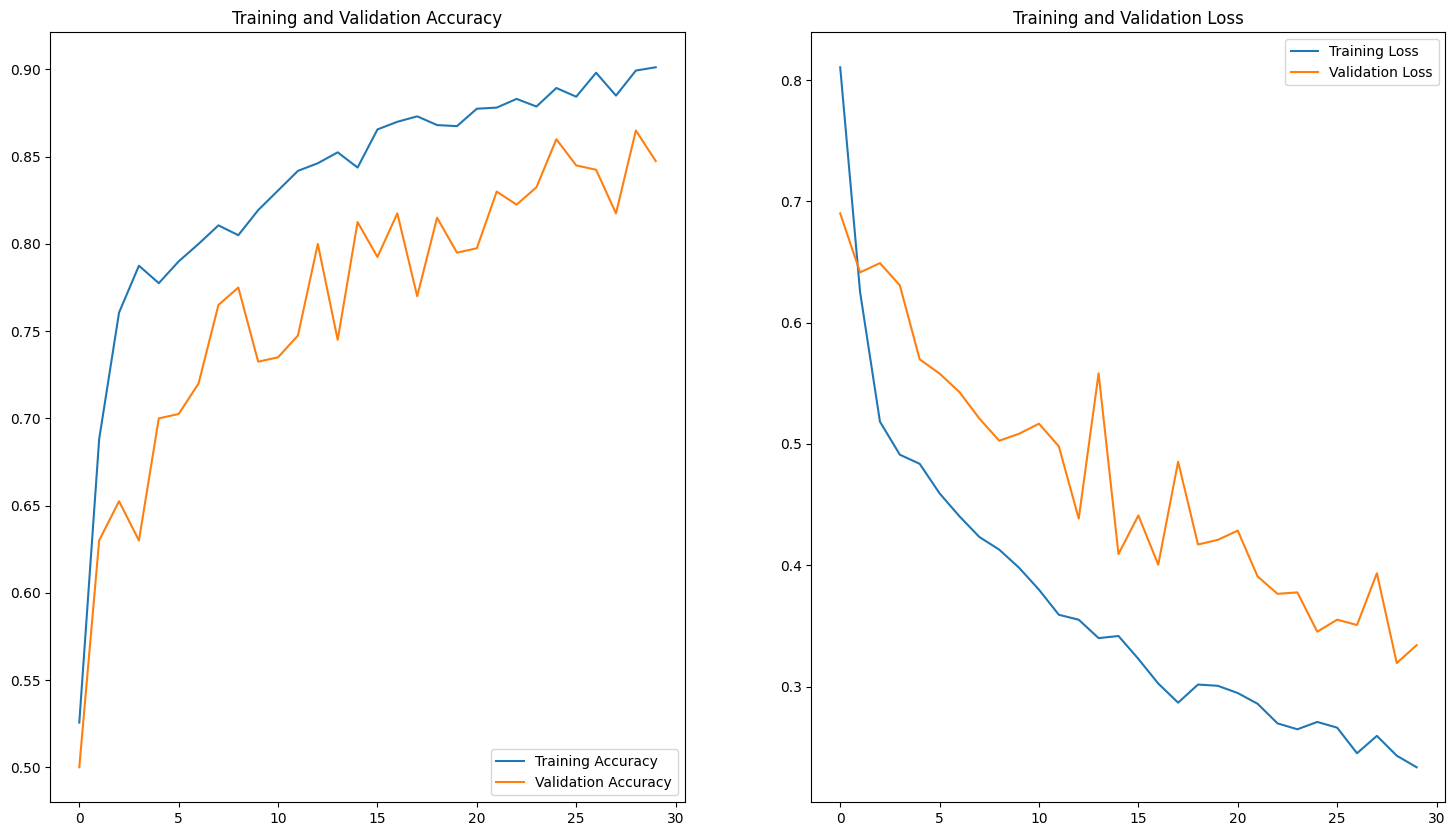

In [198]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    loss=history.history['loss']
    val_loss=history.history['val_loss']
    
    plt.figure(figsize=(18, 10))
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.savefig('Training and Validation Accuracy.png')  # << Grafiek opslaan
    
    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.savefig('Training and Validation Loss.png')
    plt.show()

plot_history(history)


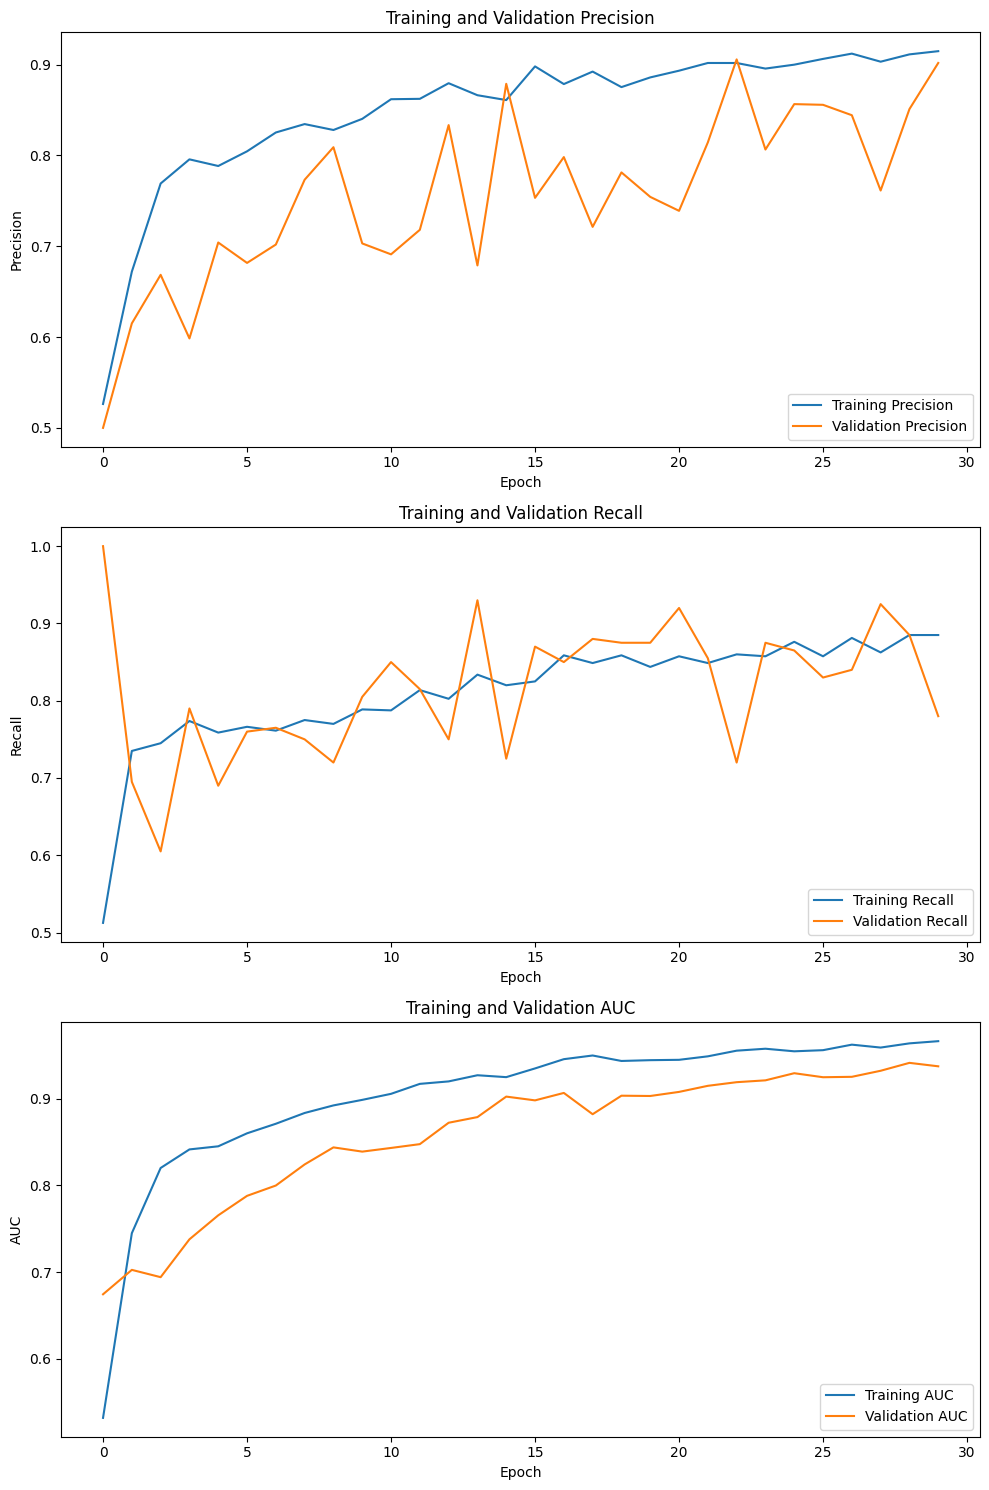

In [202]:
plt.figure(figsize=(10, 15))

# Precision
plt.subplot(3, 1, 1)
plt.plot(precision, label='Training Precision')
plt.plot(val_precision, label='Validation Precision')
plt.legend(loc='lower right')
plt.title('Training and Validation Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')

# Recall
plt.subplot(3, 1, 2)
plt.plot(recall, label='Training Recall')
plt.plot(val_recall, label='Validation Recall')
plt.legend(loc='lower right')
plt.title('Training and Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')

# AUC
plt.subplot(3, 1, 3)
plt.plot(auc, label='Training AUC')
plt.plot(val_auc, label='Validation AUC')
plt.legend(loc='lower right')
plt.title('Training and Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')

plt.tight_layout()
plt.savefig('Training_and_Validation_Precision_Recall_AUC.png')
plt.show()


## 4) Hyperparameter tuning

In [104]:
def build_model(optimizer = 'adam',
                filters=[16, 32, 64], 
                dropout=0.5, 
                learning_rate=0.001):
    
    model = Sequential([
    Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    flip,
    rotate, 
    translate,
    zoom,
    Conv2D(filters[0], 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(filters[1], 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(filters[2], 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(dropout_rate),
    Dense(128, activation = 'relu'), #added to fullfill the assignment correctly
    Dense(1, activation='sigmoid')
])

    # optimizer
    if optimizer == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)


    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=[
            tf.keras.metrics.BinaryAccuracy(name='accuracy'),
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.AUC(name='auc')
        ]
    )
    return model


In [106]:
import itertools
import pandas as pd

# Define hyperparameter ranges
dropout_list = [0.5, 0.3, 0.2]
learning_rates = [0.002, 0.001, 0.0005]
filters = [[16, 32, 64], [8, 16, 32], [32, 64, 128]]
optimizers = ['adam', 'rmsprop']

# To store results
results = []
val_accuracy_optimal = 0

# runs through all combinations
for opt, filt, d1, lr in itertools.product(optimizers, filters, dropout_list, learning_rates):

    print(f"\nTraining with d1={d1},  lr={lr}, opt={opt}, filters={filt}")
    
    model = build_model(
        optimizer = opt,
        filters=filt,
        dropout=d1,
        learning_rate=lr
    )
    
    model.compile(
        optimizer= opt,
        loss='binary_crossentropy',
        metrics=metrics
    )

    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

    history = model.fit(
        train_data_preproc,
        validation_data=val_data_preproc, 
        epochs=30,
        batch_size= batch_size,
        callbacks=[early_stop],
        verbose=1)

    # Save last epoch metrics
    last_epoch = -1
    results.append({
    'optimizer': opt, 
    'filters': filt,
    'dropout': d1,
    'learning_rate': lr,
    'val_accuracy': history.history['val_accuracy'][last_epoch],
    'val_precision': history.history['val_precision'][last_epoch],
    'val_recall': history.history['val_recall'][last_epoch],
    'val_auc': history.history['val_auc'][last_epoch],
    'batch_size': batch_size
    })

    val_accuracy = history.history['val_accuracy'][-1]
    if val_accuracy > val_accuracy_optimal:
        val_accuracy_optimal = val_accuracy
        hyperparameters_optimal = [opt, filt, d1, lr]

# Save to CSV
df = pd.DataFrame(results)
df.to_csv("grid_search_hyperparams_results2.0.csv", index=False)



Training with d1=0.5,  lr=0.002, opt=adam, filters=[16, 32, 64]
Epoch 1/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 276ms/step - accuracy: 0.5519 - auc: 0.5695 - loss: 0.7161 - precision: 0.5547 - recall: 0.4078 - val_accuracy: 0.5650 - val_auc: 0.7155 - val_loss: 0.6641 - val_precision: 0.5385 - val_recall: 0.9100
Epoch 2/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 248ms/step - accuracy: 0.7634 - auc: 0.8297 - loss: 0.5356 - precision: 0.7471 - recall: 0.7901 - val_accuracy: 0.6375 - val_auc: 0.7361 - val_loss: 0.6306 - val_precision: 0.6113 - val_recall: 0.7550
Epoch 3/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 246ms/step - accuracy: 0.7824 - auc: 0.8500 - loss: 0.4816 - precision: 0.7766 - recall: 0.7843 - val_accuracy: 0.6250 - val_auc: 0.7695 - val_loss: 0.6196 - val_precision: 0.5880 - val_recall: 0.8350
Epoch 4/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 253ms/step - accuracy: 0.7851 - auc: 0.8572 - loss: 0.4679 - precision: 0.7881 - recall: 0.7727 - val_accuracy: 0.7050 - val_auc: 0.7925 - val_loss: 0.5583 - val_precis

In [113]:
print(hyperparameters_optimal)
print(val_accuracy_optimal)

['adam', [16, 32, 64], 0.5, 0.002]
0.862500011920929


## 5) final baseline model (with validation set) 

In [203]:
combined_data_preproc = train_data_preproc.concatenate(val_data_preproc).shuffle(buffer_size=10000,  # possibly larger than dataset size.
                                                                            reshuffle_each_iteration=True)

In [204]:
model_final = build_model(
        optimizer = hyperparameters_optimal[0],
        filters=hyperparameters_optimal[1],
        dropout = hyperparameters_optimal[2],
        learning_rate= hyperparameters_optimal[3]
        #learning_rate = 0.003
    )


In [205]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

history_final = model_final.fit(
        combined_data_preproc, 
        epochs=30,
        batch_size= batch_size,
        callbacks=[early_stop],
        verbose=1)

Epoch 1/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 22s 654ms/step - accuracy: 0.5095 - auc: 0.5264 - loss: 1.4357 - precision: 0.5013 - recall: 0.5241
Epoch 2/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 530ms/step - accuracy: 0.6452 - auc: 0.6965 - loss: 0.6526 - precision: 0.7021 - recall: 0.5594 
Epoch 3/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 506ms/step - accuracy: 0.7607 - auc: 0.8026 - loss: 0.5571 - precision: 0.7689 - recall: 0.7418 
Epoch 4/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 493ms/step - accuracy: 0.7450 - auc: 0.8032 - loss: 0.5390 - precision: 0.7535 - recall: 0.7139
Epoch 5/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 498ms/step - accuracy: 0.7468 - auc: 0.8185 - loss: 0.5173 - precision: 0.7612 - recall: 0.7283
Epoch 6/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 465ms/step - accuracy: 0.7582 - auc: 0.8362 - loss: 0.4890 - precision: 0.7815 - recall: 0.7155
Epoch 7/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 480ms/step - accuracy: 0.7975 - auc: 0.8718 - loss: 0.4449 - precision: 0.8094 - recall: 0.7703
Epoch 8/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 

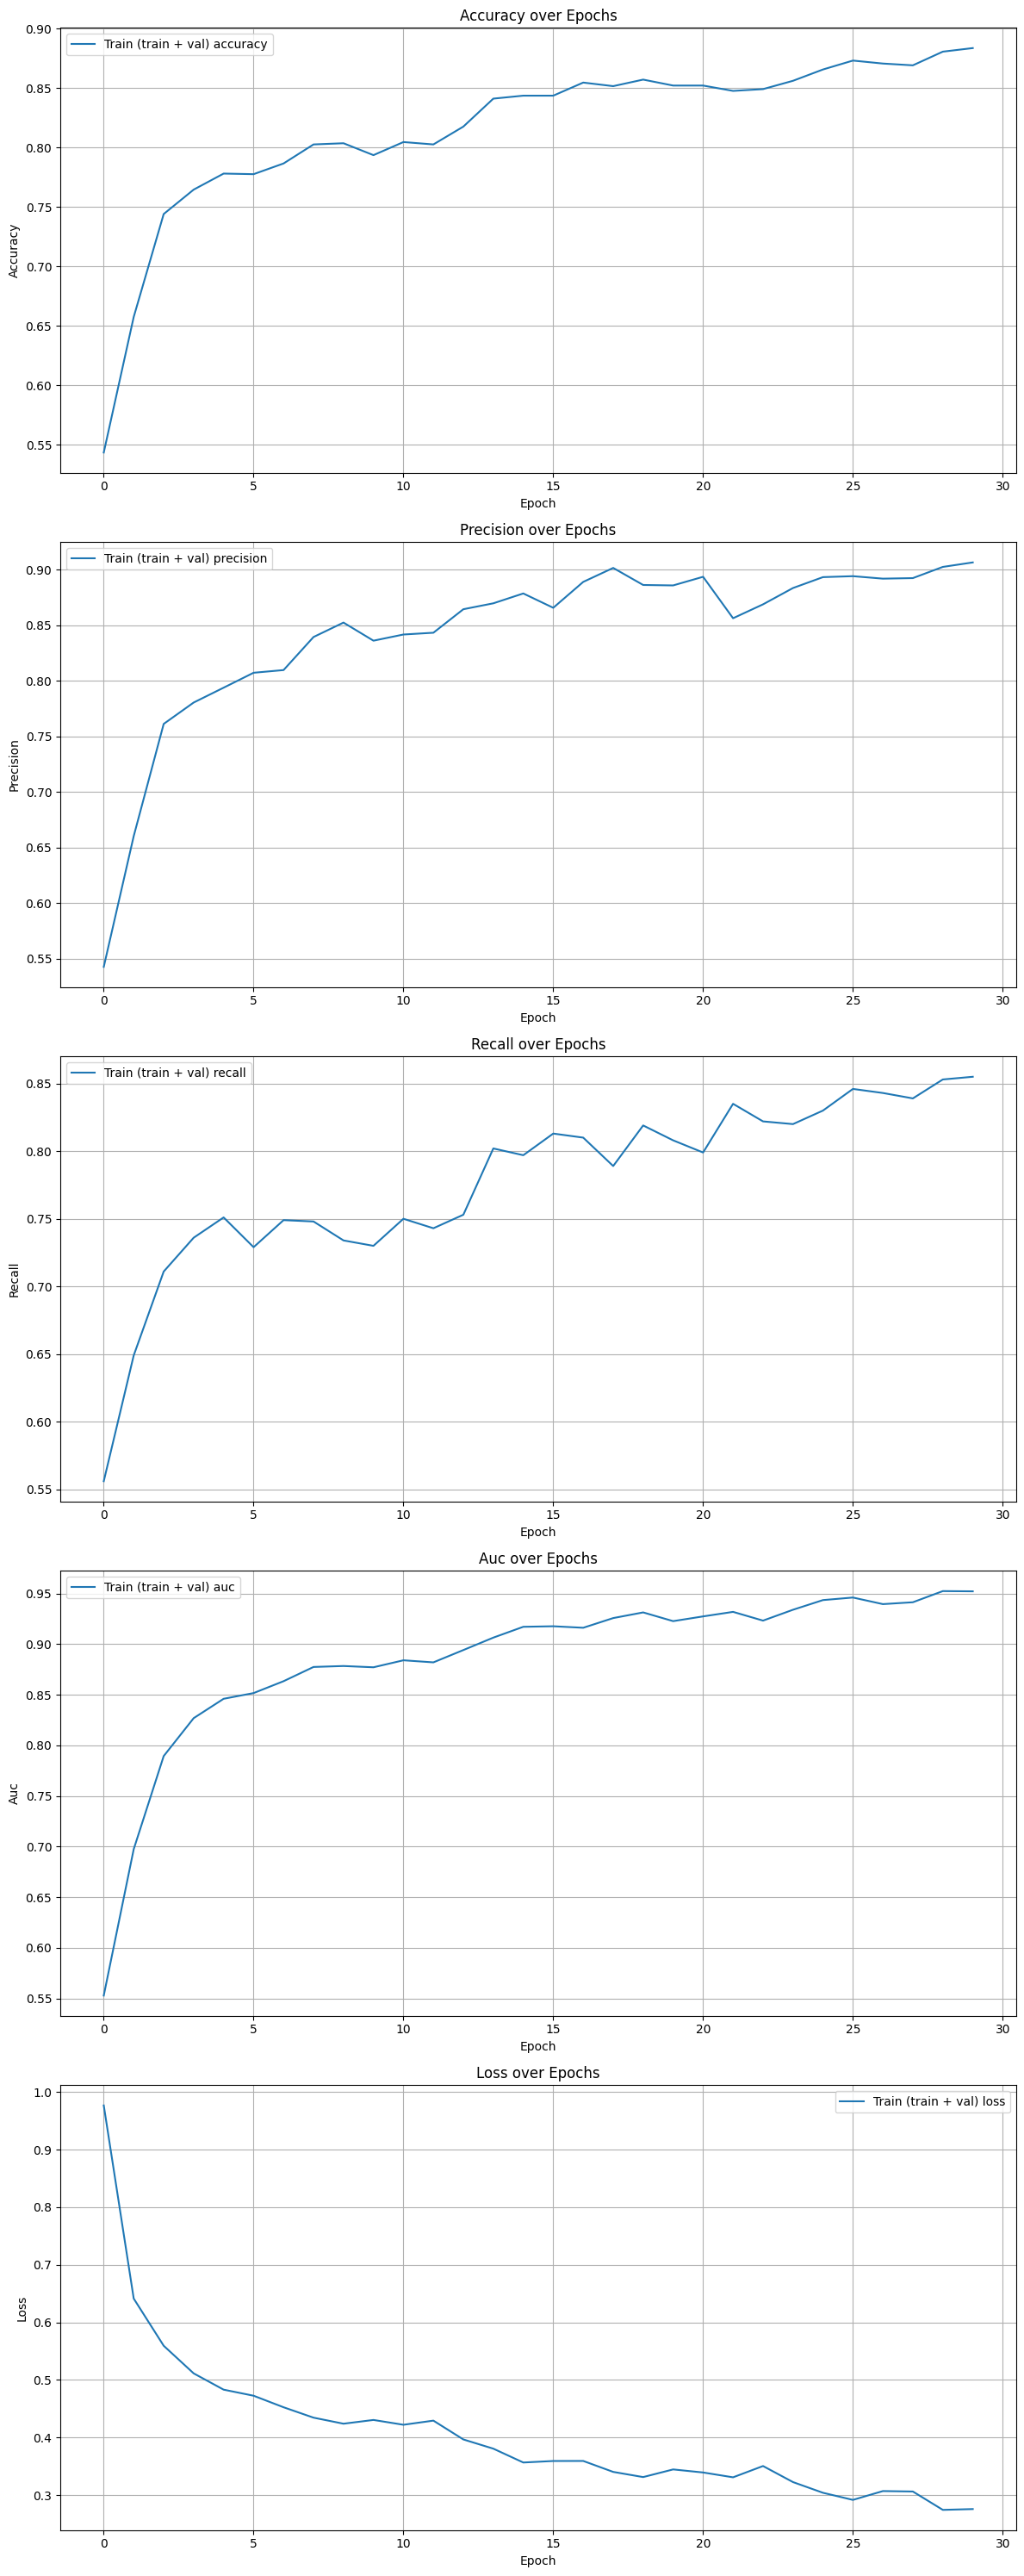

In [213]:
# List of metrics to plot
metrics_to_plot = ['accuracy', 'precision', 'recall', 'auc', 'loss']

plt.figure(figsize=(12, 30))

for i, metric in enumerate(metrics_to_plot):
    plt.subplot(5, 1, i + 1)
    plt.plot(history_final.history[metric], label=f'Train (train + val) {metric}')
    plt.title(f'{metric.capitalize()} over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid(True)
    

plt.tight_layout()
plt.savefig('retrained_training_metrics.png')
plt.show()





In [128]:
from tensorflow.keras.models import load_model

model_final.save("final_model.keras")
baselinemodel = tf.keras.models.load_model('final_model.keras')

In [129]:
final_results = baselinemodel.evaluate(test_data_preproc) #-> [loss, accuracy, precision, recall, auc]
final_loss = final_results[0]
final_acc = final_results[1]
final_precision = final_results[2]
final_recall = final_results[3]
final_auc = final_results[4]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.8349 - auc: 0.9300 - loss: 0.3792 - precision: 0.7153 - recall: 0.9110 


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


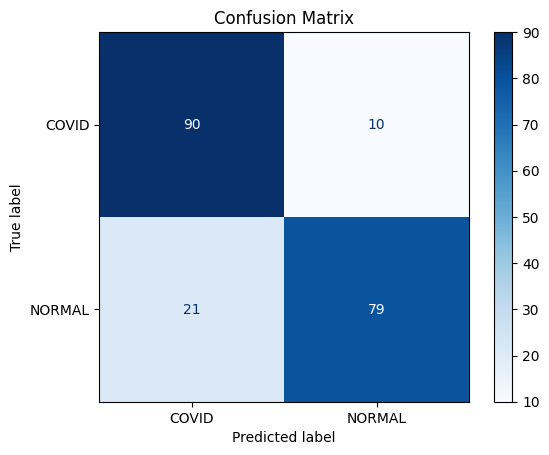

In [215]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

true_labels = []
predicted_labels = []

for images, labels in test_data_preproc:
    predictions = (baselinemodel.predict(images) > 0.75).astype("int32").flatten()
    
    true_labels.extend(labels.numpy())
    predicted_labels.extend(predictions)

cm = confusion_matrix(true_labels, predicted_labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["COVID", "NORMAL"]) 
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
#plt.savefig('confusion_matrix.png')  
plt.savefig('confusion_matrix075.png')  
plt.show()

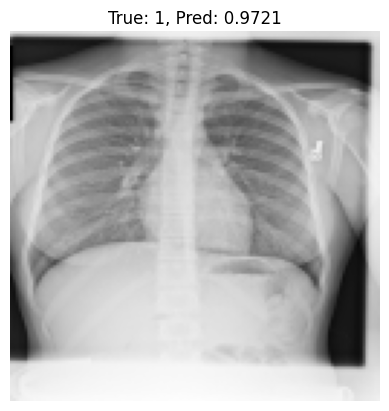

True: NORMAL, Pred: NORMAL


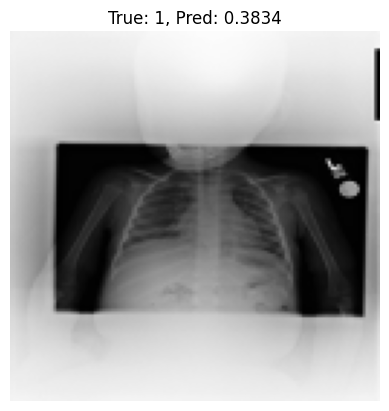

True: NORMAL, Pred: COVID


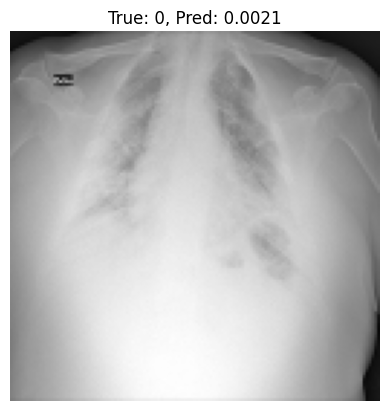

True: COVID, Pred: COVID


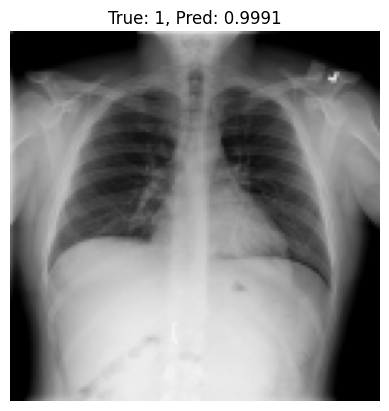

True: NORMAL, Pred: NORMAL


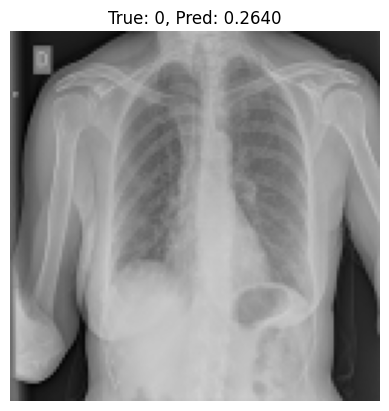

True: COVID, Pred: COVID


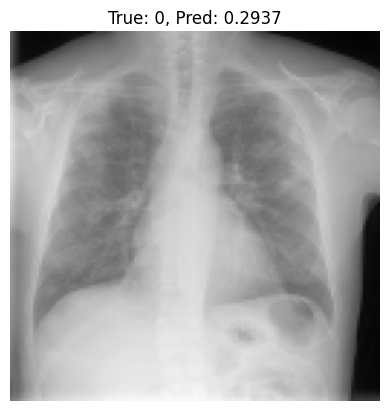

True: COVID, Pred: COVID


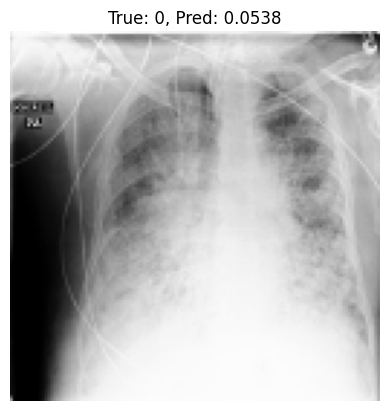

True: COVID, Pred: COVID


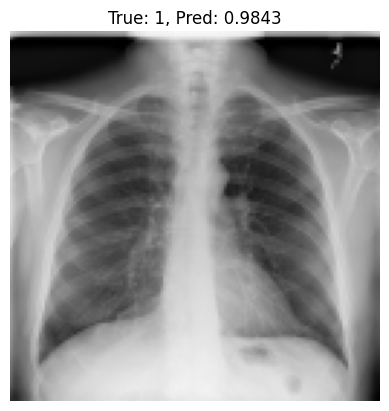

True: NORMAL, Pred: NORMAL


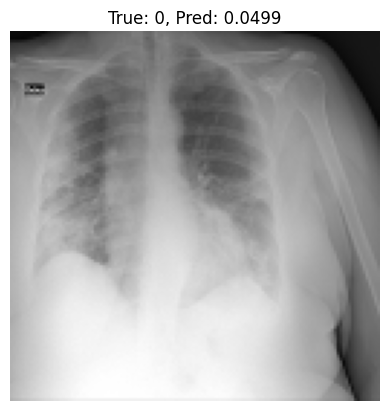

True: COVID, Pred: COVID


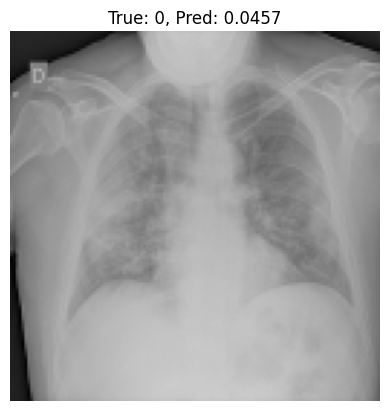

True: COVID, Pred: COVID


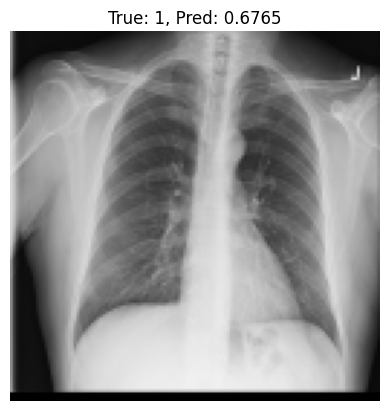

True: NORMAL, Pred: COVID


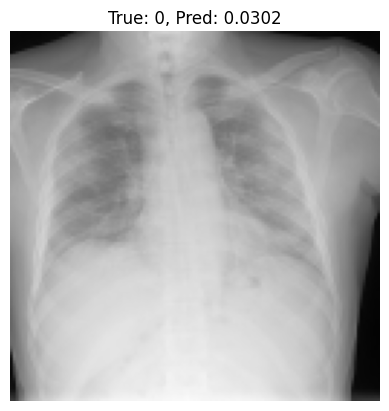

True: COVID, Pred: COVID


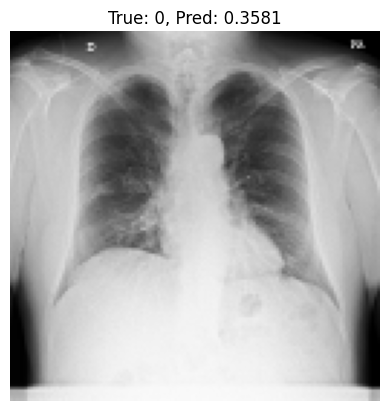

True: COVID, Pred: COVID


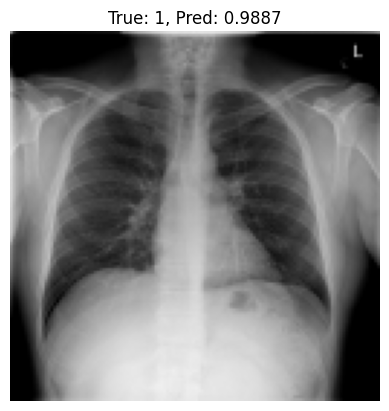

True: NORMAL, Pred: NORMAL


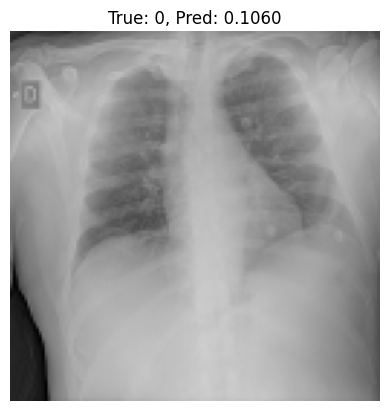

True: COVID, Pred: COVID


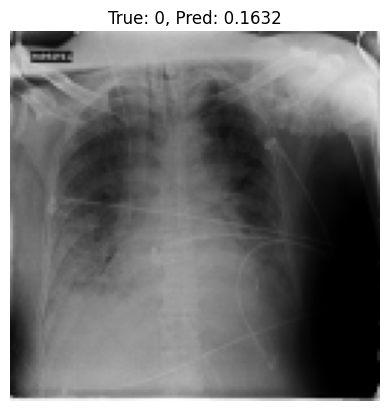

True: COVID, Pred: COVID


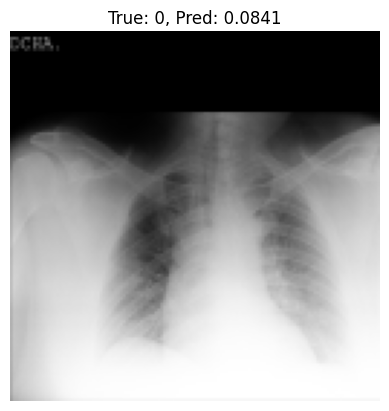

True: COVID, Pred: COVID


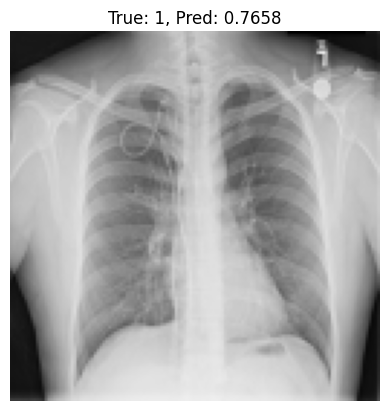

True: NORMAL, Pred: NORMAL


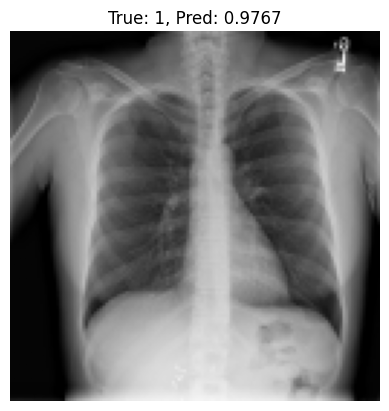

True: NORMAL, Pred: NORMAL


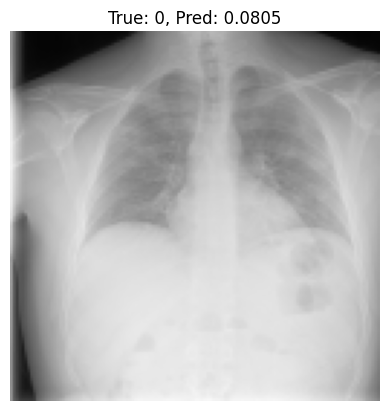

True: COVID, Pred: COVID


In [219]:
x_batch, y_batch = next(iter(test_data_preproc))  # use iter() to iterate properly

y_pred = model.predict(x_batch, verbose=0)

for i in range(20): 
    img = x_batch[i]
    true_label = y_batch[i]
    pred_label = y_pred[i][0]  # binary classification

    plt.figure()
    plt.imshow(img.numpy().squeeze())
    plt.title(f"True: {int(true_label)}, Pred: {pred_label:.4f}")
    plt.axis("off")
    plt.show()
    print(f"True: {['COVID', 'NORMAL'][int(true_label)]}, Pred: {['COVID', 'NORMAL'][float(pred_label) >0.75]}")
    
